<a href="https://colab.research.google.com/github/tkasod2/TIL/blob/main/prj_analysis/%EC%8B%A4%EC%A0%84_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_6_%EA%B0%90%EC%84%B1_%EB%B6%84%EC%84%9D%EC%9C%BC%EB%A1%9C_%EB%A6%AC%EB%B7%B0_%EB%B0%98%EC%9D%91_%EC%82%B4%ED%94%BC%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 47.1 MB/s 
     |████████████████████████████████| 15.7 MB 11.8 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=4f825e16842dc66aafb5b7bc1bc83622d58f7a0c74a96a28777f0e8b2b35b7ed
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take in

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/"
DATA_DIR_PATH = "공부/zero_base_data_analysis/[바로-써먹는-데이터-분석]-강의자료-new4/2부/Part 3. 출시한 제품에 대한 반응은 어떤가요_ - 리뷰 텍스트 분석/실전 프로젝트 6. 감성 분석으로 리뷰 반응 살피기/"

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 데이터 살펴보기

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_FILENAME = "Womens Clothing E-Commerce Reviews.csv" # 디렉토리 내 데이터 파일의 이름
data_path = Path(DRIVE_PATH, DATA_DIR_PATH, DATA_FILENAME)

In [ ]:
# 데이터 불러오기
df = pd.read_csv(data_path, index_col=0)

In [ ]:
# 데이터 살펴보기
df.head(10)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [ ]:
# 데이터 개수
len(df)

23486

In [ ]:
# 그래프 테마 설정
sns.set_theme(style="whitegrid", palette="pastel")

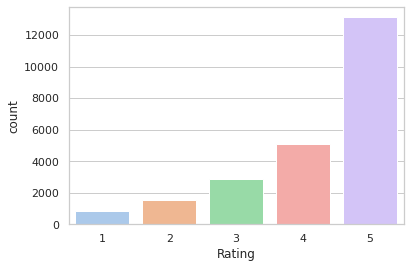

In [ ]:
# 점수 분포
sns.countplot(data=df, x="Rating")
plt.show()

## 대부분 5점의 별점을 준다
## 관대한 평가가 주를 이룬다.

In [ ]:
# 리뷰 글자수
df['Review Text'].dropna().map(len)

0         53
1        303
2        500
3        124
4        192
        ... 
23481    131
23482    223
23483    208
23484    427
23485    110
Name: Review Text, Length: 22641, dtype: int64

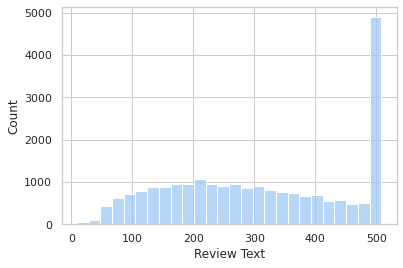

In [ ]:
# 리뷰 길이 분포 (글자수)
sns.histplot(df['Review Text'].dropna().map(len))
plt.show()
## 500글자 가까운 리뷰가 굉장히 많다.
## 글자제한이 있지 않을까?

In [ ]:
# 가장 긴 리뷰의 글자수
df['Review Text'].dropna().map(len).max()


508

In [ ]:
# 리뷰 단어수
df['Review Text'].dropna().map(lambda x: len(x.split()))

0         8
1        62
2        98
3        22
4        36
         ..
23481    28
23482    38
23483    42
23484    86
23485    19
Name: Review Text, Length: 22641, dtype: int64

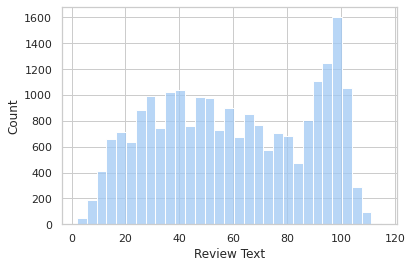

In [ ]:
# 리뷰 길이 분포 (단어수)
sns.histplot(df['Review Text'].dropna().map(lambda x: len(x.split())))
plt.show()


## 보통 100단어 내외로 리뷰가 작성이 되었다.

In [ ]:
# 가장 긴 리뷰의 단어수
df['Review Text'].dropna().map(lambda x: len(x.split())).max()

115

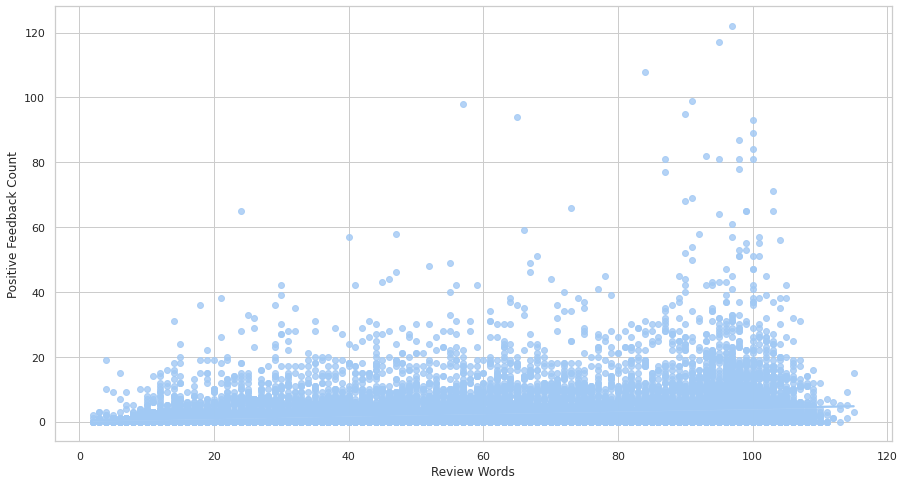

In [ ]:
# 리뷰 길이와 리뷰 투표수
df["Review Words"] = df['Review Text'].dropna().map(lambda x: len(x.split()))
g = sns.regplot(x="Review Words", y="Positive Feedback Count", data=df)
g.figure.set_size_inches(15, 8)
plt.show()

# 리뷰의 길이와 긍정적 피드백과의 선형적 관계는 없는것으로 보인다.

In [ ]:
df_clean = df.dropna(subset=['Review Text']).copy()

In [ ]:
# 점수 분포에서 5점이 압도적으로 많기 때문에, 5점을 positive, 4점 이하를 negative로 둔다.
df_clean['Label'] = df_clean['Rating'] == 5

# 텍스트 전처리

In [ ]:
import spacy
from collections import Counter
import math
from tqdm import tqdm

In [ ]:
# 필요한 리소스를 로드해야 한다. 영어 리소스 로드.
nlp = spacy.load("en_core_web_sm")

In [ ]:
%%time
tokens_normalized = []
for doc in tqdm(nlp.pipe(df_clean['Review Text'].str.lower())):
  lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space] # 문장부호, 공백 제거
  tokens_normalized.append(lemmas)#lemmatization된 데이터로 토큰화


22641it [02:21, 159.57it/s]

CPU times: user 2min 14s, sys: 3.24 s, total: 2min 17s
Wall time: 2min 21s


**Phrase modeling (bigram & trigram)**

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
%%time
# gensim을 이용해서 phrase modeling을 한다
bigram_model = Phrases(tokens_normalized)
bigram_phraser = Phraser(bigram_model)

CPU times: user 3.72 s, sys: 25.8 ms, total: 3.74 s
Wall time: 3.74 s


In [ ]:
tokens_bigram = []
for s in tokens_normalized:
    bigram_phrases = bigram_phraser[s]
    tokens_bigram.append(bigram_phrases)

In [ ]:
# 추가 반복을 통해 trigram 확보
trigram_model = Phrases(tokens_bigram)
trigram_phraser = Phraser(trigram_model)

In [ ]:
tokens_trigram = []
for s in tokens_bigram:
    trigram_phrases = trigram_phraser[s]
    trigram_phrases = [token for token in trigram_phrases if token not in nlp.Defaults.stop_words and token != '-PRON-']
    tokens_trigram.append(trigram_phrases)

In [ ]:
preprocessed_sentences = []
for s in tokens_trigram:
  preprocessed_sentences.append(' '.join(s))

In [ ]:
df_clean['Reviews Preprocessed'] = preprocessed_sentences

In [ ]:
df_clean.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Words,Label,Reviews Preprocessed
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8.0,False,absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62.0,True,love dress sooo pretty happen find store glad ...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98.0,False,such_high_hope dress want work initially order...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22.0,True,love love love jumpsuit fun flirty fabulous ev...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36.0,True,shirt flattering adjustable tie perfect length...


학습용 데이터와 테스트용 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split
# scikit-learn의 train_test_split에서 학습용 데이터와 테스트용 데이터의 디폴트 비율은 75:25이다.
df_train, df_test = train_test_split(df_clean, random_state=0)

In [ ]:
def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    bigrams = bigram_phraser[lemmas]
    trigrams = trigram_phraser[bigrams]
    tokens_normalized = [lemma for lemma in trigrams if lemma not in nlp.Defaults.stop_words and lemma != '-PRON-']
    return tokens_normalized

# 사전으로 하는 감성 분석

감성어 사전을 만들고 이를 이용해 감성 분석 정확도를 구해보자

In [ ]:
# Sampled and modified from https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt
# 긍정 단어는 1, 부정 단어는 -1로 표기한다.
sentiment_vocab = {
 'adorable': 1,
 'adore': 1,
 'allow': 1,
 'amazing': 1,
 'appreciate': 1,
 'attractive': 1,
 'avoid': -1,
 'awesome': 1,
 'awful': -1,
 'awkward': -1,
 'bad': -1,
 'beautiful': 1,
 'beautifully': 1,
 'beauty': 1,
 'best': 1,
 'better': 1,
 'bother': -1,
 'bright': 1,
 'bummer': -1,
 'care': 1,
 'careful': 1,
 'casual': 1,
 'certainly': 1,
 'chance': 1,
 'chic': 1,
 'classy': 1,
 'comfort': 1,
 'comfortable': 1,
 'comfortably': 1,
 'compliment': 1,
 'cool': 1,
 'crazy': -1,
 'create': 1,
 'cut': -1,
 'cute': 1,
 'definitely': 1,
 'difficult': -1,
 'disappoint': -1,
 'disappointed': -1,
 'disappointing': -1,
 'disappointment': -1,
 'dream': 1,
 'easily': 1,
 'easy': 1,
 'elegant': 1,
 'enjoy': 1,
 'excellent': 1,
 'excited': 1,
 'expose': -1,
 'fabulous': 1,
 'fantastic': 1,
 'favorite': 1,
 'feeling': 1,
 'fine': 1,
 'fit': 1,
 'flattering': 1,
 'flirty': 1,
 'forgiving': 1,
 'friend': 1,
 'fun': 1,
 'generous': 1,
 'glad': 1,
 'good': 1,
 'gorgeous': 1,
 'great': 1,
 'hand': 1,
 'happy': 1,
 'hate': -1,
 'help': 1,
 'hesitant': -1,
 'hesitate': -1,
 'hide': -1,
 'holiday': 1,
 'honestly': 1,
 'hope': 1,
 'hopefully': 1,
 'hug': 1,
 'huge': 1,
 'interesting': 1,
 'itchy': -1,
 'justice': 1,
 'lack': -1,
 'like': 1,
 'loose': -1,
 'lose': -1,
 'love': 1,
 'lovely': 1,
 'low': -1,
 'miss': -1,
 'nice': 1,
 'nicely': 1,
 'odd': -1,
 'ok': 1,
 'okay': 1,
 'party': 1,
 'perfect': 1,
 'perfection': 1,
 'perfectly': 1,
 'pleased': 1,
 'pretty': 1,
 'problem': -1,
 'recommend': 1,
 'regret': -1,
 'relaxed': 1,
 'rich': 1,
 'ridiculous': -1,
 'romantic': 1,
 'ruin': -1,
 'sad': -1,
 'sadly': -1,
 'seriously': -1,
 'sexy': 1,
 'solid': 1,
 'special': 1,
 'stop': -1,
 'straight': 1,
 'strange': -1,
 'stunning': 1,
 'substantial': 1,
 'super': 1,
 'support': 1,
 'sure': 1,
 'surprise': 1,
 'surprised': 1,
 'surprisingly': 1,
 'sweet': 1,
 'terrible': -1,
 'thank': 1,
 'thrill': 1,
 'trouble': -1,
 'true': 1,
 'truly': 1,
 'uncomfortable': -1,
 'unfortunately': -1,
 'vibrant': 1,
 'warm': 1,
 'waste': -1,
 'weird': -1,
 'winner': 1,
 'wish': 1,
 'wonderful': 1,
 'wonderfully': 1,
 'worried': -1,
 'worry': -1,
 'worth': 1,
 'wow': 1,
 'wrong': -1,
 'yes': 1}

In [ ]:
print(sentiment_vocab.get('wonderful',0))
print(sentiment_vocab.get('worry',0))
print(sentiment_vocab.get('yeah'))
print(sentiment_vocab.get('yeah',0))

1
-1
None
0


In [ ]:
# 텍스트를 받아 점수를 반환하는 예측 함수를 만든다.
def predict_with_dictionary(normalized_text):
    tokens = normalized_text.split()
    review_score = 0
    for token in tokens:
      token_score = sentiment_vocab.get(token, 0) # 감성어 사전에 있으면 token 값, 아니면 0
      review_score = review_score + token_score
    review_score = review_score/len(tokens)
    pred = review_score > 0
    return pred

In [ ]:
index = 0
print(df_test['Reviews Preprocessed'].iloc[index])
print()
predict_with_dictionary(df_test['Reviews Preprocessed'].iloc[index])

beautiful versatile dress extremely forgiving post_baby_body stylish classy



True

In [ ]:
# 정답과 예측
predictions_with_dict = df_test['Reviews Preprocessed'].map(predict_with_dictionary)

In [ ]:
# 정확도 (accuracy) 구하기
corrects_with_dict = df_test['Label'] == predictions_with_dict
corrects_with_dict.sum() / len(corrects_with_dict)

0.5797562268150503

# 토픽으로 하는 감성 분석

토픽 모델링을 통해 문서의 토픽을 추출하고, 이를 이용해 긍부정을 예측해보자

In [ ]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaMulticore

In [ ]:
dictionary = Dictionary(tokens_trigram) # 전처리된 token으로 dictionary를 만듦
dictionary.filter_extremes(no_below=10, no_above=0.4) # 필터링
dictionary.compactify()

In [ ]:
def make_bow_corpus(tokens):
    """
    generator function to read in reviews from the file
    and output a bag-of-words represention of the text
    """
    for review in tokens:
        yield dictionary.doc2bow(review) # document를 BOW형태로 바꿔줌

corpus_filepath = 'corpus.mm'
MmCorpus.serialize(corpus_filepath, make_bow_corpus(tokens_trigram))
review_corpus = MmCorpus(corpus_filepath)

In [ ]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning)
lda = LdaMulticore(review_corpus,
                    num_topics=10, # topic 10개로 정의
                    id2word=dictionary,
                    workers=2,
                    random_state=13)

CPU times: user 12.6 s, sys: 1.08 s, total: 13.7 s
Wall time: 18.9 s


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
ldavis = pyLDAvis.gensim_models.prepare(topic_model=lda, 
                                     corpus=review_corpus, 
                                     dictionary=dictionary)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.display(ldavis)

# 단어의 빈도와, 특징적으로 나왔는지를 기준으로 정리 가능
# lambda를 조절해서 정의할 수 있음


In [ ]:
# 참고: 안타깝게도 gensim과 pyLDAvis는 동일한 토픽 인덱스를 공유하지 않는다. 
# 아래에 현재 토픽 모델에서 두 인덱스가 어떻게 매핑되는지 적어놓았다.
# gensim index -> pyLDAvis index
#  0 -> 7
#  1 -> 8
#  2 -> 6
#  3 -> 9
#  4 -> 4
#  5 -> 10
#  6 -> 5
#  7 -> 3
#  8 -> 1
#  9 -> 2

In [54]:
lda.show_topic(0)

[('fit', 0.03224418),
 ('look', 0.02248444),
 ('love', 0.019435346),
 ('size', 0.017974112),
 ('small', 0.014958014),
 ('order', 0.014951397),
 ('like', 0.014943746),
 ('dress', 0.014254757),
 ('wear', 0.012074377),
 ('medium', 0.011938189)]

In [56]:
# 토픽 마다 이름을 정해주고 긍부정 사전을 만듦
topic_sentiments = {0: ('fit', 1),
               1: ('leggings & jeans', 0),
               2: ('waist fit', -1),
               3: ('skirt & blouse', 0),
               4: ('nice color', 1),
               5: ('great', 1),
               6: ('fabric', -1),
               7: ('special occasion', 1),
               8: ('size problem', -1),
               9: ('love', 1),
              }

In [59]:
# LDA로 긍부정을 예측하는 함수를 만든다.
def get_lda(normalized_text):
    tokens = normalized_text.split()
    bow = dictionary.doc2bow(tokens)
    lda_result = lda[bow]
    return lda_result

def get_sentiment(normalized_text):
    review_lda = get_lda(normalized_text)
    sentiments = [(topic_sentiments[topic][1] * frequency, frequency) for topic, frequency in review_lda 
                  if topic_sentiments[topic][1] != 0]
    if not sentiments:
        return 0
    else:
        return sum(senti for senti, freq in sentiments) / sum(freq for senti, freq in sentiments)

def predict_with_lda(normalized_text):
    sentiment = get_sentiment(normalized_text)
    return sentiment >= 0

In [60]:
# 리뷰와 LDA 결과를 눈으로 보자
warnings.filterwarnings("ignore", category=DeprecationWarning)
def describe_review_from_raw(text, min_frequency=0.1):
    tokens = preprocess_text(text)
    normalized_text = ' '.join(tokens)
    review_lda = get_lda(normalized_text)
    sentiment = get_sentiment(normalized_text)

    for topic, frequency in sorted(review_lda, key=lambda x: x[1], reverse=True):

        if frequency < min_frequency: continue
        print('{:25} {}'.format(topic_sentiments[topic][0], round(frequency, 3)))

    print()
    
    print("positiveness : {}".format(sentiment))

In [61]:
text = df_train['Review Text'].iloc[0]
print(text)
print()
describe_review_from_raw(text)
# love(긍정), waist fit(부정) 의 topic으로 정리

I love this shirt, i had my eye on it for awhile but wasn't sure what size i'd be, so i went to the store to try. they only had a small which i figured i would be but it was a little large and not as fitted as i would like it across the chest. i got an xs and it was perfect; i am 5'1 about 120 lbs and a small c cup and it fits great. i love it!!

love                      0.5009999871253967
waist fit                 0.46700000762939453

positiveness : 0.03557429368216298


In [62]:
# 정답과 예측
predictions_with_lda = df_test['Reviews Preprocessed'].map(predict_with_lda)

# 정확도 (accuracy) 구하기
corrects_with_lda = df_test['Label'] == predictions_with_lda
corrects_with_lda.sum() / len(corrects_with_lda)



0.608549726196785

# 통계로 하는 감성 분석

로지스틱 회귀를 이용해 텍스트 분류를 해보자

In [63]:
# vectorizer를 초기화하기
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [64]:
# 사전(vocabulary) 학습하기. document-term matrix를 만드는 데 사용됨
vect.fit(df_train['Reviews Preprocessed'])
X_train_dtm = vect.transform(df_train['Reviews Preprocessed'])

In [65]:
X_train_dtm

<16980x11563 sparse matrix of type '<class 'numpy.int64'>'
	with 357673 stored elements in Compressed Sparse Row format>

In [68]:
X_train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [66]:
# 테스트 데이터를 document-term matrix로 바꾸기 (학습된 사전 활용)
X_test_dtm = vect.transform(df_test['Reviews Preprocessed'])
X_test_dtm

<5661x11563 sparse matrix of type '<class 'numpy.int64'>'
	with 116412 stored elements in Compressed Sparse Row format>

In [69]:
# logistic regression model을 불러오고 초기화
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)

In [70]:
# X_train_dtm를 이용해 모델 학습
%time logreg.fit(X_train_dtm, df_train['Label'])

CPU times: user 1.42 s, sys: 1.76 s, total: 3.17 s
Wall time: 1.65 s


LogisticRegression(max_iter=1000)

In [71]:
# X_test_dtm에 대해 클래스 예측
y_pred_class = logreg.predict(X_test_dtm)

In [72]:
# X_test_dtm에 대해 확률 예측
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.86292066, 0.37799351, 0.05795736, ..., 0.01871669, 0.92682195,
       0.97924315])

In [73]:
print(df_test['Review Text'].iloc[0])
print()
print(y_pred_prob[0])

Beautiful and very versatile dress. extremely forgiving for post baby bodies, while stylish and classy.

0.862920658341584


In [74]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [75]:
# 클래스 예측 정확도 구하기
accuracy_score(df_test['Label'], y_pred_class)

0.773891538597421

# 딥러닝으로 하는 감성 분석

미리 학습된 딥러닝 모델을 불러와 파인튜닝(fine-tuning)을 통해 텍스트 분류를 해보자

허깅페이스의 transformers 라이브러리를 활용한다.
https://huggingface.co/docs/transformers/index

GPU 사용 추천*

In [76]:
!pip install transformers datasets

     |████████████████████████████████| 3.4 MB 8.3 MB/s 
     |████████████████████████████████| 306 kB 67.7 MB/s 
     |████████████████████████████████| 3.3 MB 58.9 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
     |████████████████████████████████| 895 kB 67.9 MB/s 
     |████████████████████████████████| 61 kB 613 kB/s 
     |████████████████████████████████| 243 kB 57.1 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 132 kB 51.6 MB/s 
     |████████████████████████████████| 192 kB 71.2 MB/s 
     |████████████████████████████████| 271 kB 72.5 MB/s 
     |████████████████████████████████| 160 kB 73.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [77]:
# 토크나이저 import
from transformers import AutoTokenizer
# 이 실습에서는 BERT의 다국어 버전 base 모델을 사용할 것이다. 다국어 버전에는 한국어도 지원한다.
# large 모델도 존재하며, base보다 모델 크기가 크고 정확도가 더 높다. vs large
# cased라는 말은 소문자로 normalized 되지 않았다는 뜻이다. vs uncased
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [78]:
# 시험 삼아 무작위의 글을 토크나이징 해보자
# 토크나이징 결과로 만들어진 단어 인덱스의 리스트가 input_ids에 담긴다.
print(df_train['Review Text'].loc[0])
tokenizer(df_train['Review Text'].loc[0], padding="max_length", truncation=True)
# 각각의 integer는 몇번째 vocabulary인지 디스플레이
# 예를들어, Absolutely 는 101번째

Absolutely wonderful - silky and sexy and comfortable


{'input_ids': [101, 108394, 10454, 11367, 11304, 14446, 118, 33694, 11445, 10111, 18549, 10157, 10111, 10212, 81587, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [79]:
# 토크나이징을 여러번 반복하기 쉽게 함수로 만든다.
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [82]:
df_train[['Review Text','Label']].head()

,Review Text,Label
9616,"I love this shirt, i had my eye on it for awhi...",True
1352,I found this dress at my local retailer must b...,True
17500,I wanted to love this skirt. i love high-waist...,False
370,I love this top. i got it on sale and am so gl...,True
23208,"First off, let me say that i am 52 and don't o...",True


In [80]:
# datasets 라이브러리를 불러온다.
# 허깅페이스에서 개발한 자연어 등 여러 데이터셋을 다루기 위한 라이브러리이다.
from datasets import Dataset

# 리뷰 텍스트와 레이블로 데이터셋을 만든다.
dataset_train = Dataset.from_dict({'text': df_train['Review Text'], 'label': df_train['Label']})
dataset_test = Dataset.from_dict({'text': df_test['Review Text'], 'label': df_test['Label']})

In [83]:
# dataset의 map 함수를 이용해 토크나이징 함수를 적용한다.
dataset_train_tokenized = dataset_train.map(tokenize_function, batched=True)
dataset_test_tokenized = dataset_test.map(tokenize_function, batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [84]:
# 모델을 불러온다.
# 분류용으로 불러오며, 분류하는 레이블은 2개이다. -> hyper params : num)labels
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [85]:
# 모델을 학습시키는 인자(arguments)를 정의하는 클래스이다.
# 데이터셋 전체를 한번 학습하는 것을 epoch이라 하며, 보통 여러 epoch을 돌며 모델을 학습시킨다.
# 빠른 결과를 보기 위해 1 epoch만 학습한다.
from transformers import TrainingArguments

training_args = TrainingArguments("runs", num_train_epochs=1)

In [86]:
# 정확도를 계산하기 위한 함수를 정의한다.

import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [87]:
# 모델을 학습시키는 Trainer 클래스를 정의한다.
# 모델과 데이터셋, 정확도 측정 함수가 들어간다.

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_tokenized,
    eval_dataset=dataset_test_tokenized,
    compute_metrics=compute_metrics,
)

In [88]:
# 학습을 진행한다.
# GPU 서버에서 1 epoch을 학습하면 약 1시간이 걸린다.
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 16980
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2123


Step,Training Loss
500,0.638100
1000,0.582700
1500,0.527600
2000,0.488600


Saving model checkpoint to runs/checkpoint-500
Configuration saved in runs/checkpoint-500/config.json
Model weights saved in runs/checkpoint-500/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-1000
Configuration saved in runs/checkpoint-1000/config.json
Model weights saved in runs/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-1500
Configuration saved in runs/checkpoint-1500/config.json
Model weights saved in runs/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-2000
Configuration saved in runs/checkpoint-2000/config.json
Model weights saved in runs/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2123, training_loss=0.5538239283658287, metrics={'train_runtime': 1047.4812, 'train_samples_per_second': 16.21, 'train_steps_per_second': 2.027, 'total_flos': 4467625720012800.0, 'train_loss': 0.5538239283658287, 'epoch': 1.0})

In [89]:
# 학습이 끝난 모델을 평가한다.
# 약 80%의 정확도를 기록하는 것을 볼 수 있다.
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 5661
  Batch size = 8


{'epoch': 1.0,
 'eval_accuracy': 0.7929694400282635,
 'eval_loss': 0.4777405560016632,
 'eval_runtime': 112.6355,
 'eval_samples_per_second': 50.259,
 'eval_steps_per_second': 6.286}

In [90]:
# raw text를 받아서 파인튜닝된 bert 모델로 5점 리뷰인지 아닌지 판별하는 함수
def predict_with_bert(text):
    inputs = tokenizer(text, return_tensors="pt")
    inputs = inputs.to(model.device)
    outputs = model(**inputs)
    prediction = outputs['logits'].argmax().item() # argmax로 1,0을 만들어줌. 1이면 긍정/0이면 부정
    return prediction > 0

In [91]:
print(df_test['Review Text'].iloc[0])
print()
predict_with_bert(df_test['Review Text'].iloc[0])

Beautiful and very versatile dress. extremely forgiving for post baby bodies, while stylish and classy.



True